In [1]:
# This is a copy of my private kaggle kernel: https://www.kaggle.com/joatom/nn-model-skf
# fork of https://www.kaggle.com/inversion/atomic-distance-benchmark/

#J-Coupling:https://www.youtube.com/watch?v=vnkk3eli1Hc

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from fastai.tabular import *

import gc
import psutil
import os
import time
from functools import reduce

print(os.listdir("../input"))

['champs-scalar-coupling', 'main-features-2', 'main-features', 'lgb-model']


In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mmse
from sklearn.metrics import mean_absolute_error as mmae

from sklearn.model_selection import KFold,GroupKFold,StratifiedKFold


# General Functions

In [3]:
in_path='../input/champs-scalar-coupling/'
mf_path='../input/main-features/'
mf2_path='../input/main-features-2/'
lgb_path='../input/lgb-model/'

In [4]:
train=pd.read_pickle(mf2_path+'train_mf2_ext_1JHN.zip',compression='zip')
#train[['2J_nn','nn2_1']].describe()
#train=pd.read_csv(lgb_path+'submission_last.csv')
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,num_atoms_in_mol_x,r_1_0,nn_idx_1_0,...,cos_dist_6_1,solid_angle_6_1,cos_dist_7_1,solid_angle_7_1,cos_dist_8_1,solid_angle_8_1,cos_dist_9_1,solid_angle_9_1,cos_dist_10_1,solid_angle_10_1
10,10,dsgdb9nsd_000002,1,0,1JHN,32.688900,H,4,0.494998,0,...,0.0,1.840302,0.0,1.840302,0.0,1.840302,0.0,1.840302,0.0,1.840302
13,13,dsgdb9nsd_000002,2,0,1JHN,32.689098,H,4,3.696948,0,...,0.0,1.840302,0.0,1.840302,0.0,1.840302,0.0,1.840302,0.0,1.840302
15,15,dsgdb9nsd_000002,3,0,1JHN,32.690498,H,4,3.691235,0,...,0.0,1.840302,0.0,1.840302,0.0,1.840302,0.0,1.840302,0.0,1.840302
97,97,dsgdb9nsd_000012,3,0,1JHN,55.525200,H,6,4.541935,0,...,0.0,1.840302,0.0,1.840302,0.0,1.840302,0.0,1.840302,0.0,1.840302
101,101,dsgdb9nsd_000012,4,0,1JHN,54.735901,H,6,4.501441,0,...,0.0,1.840302,0.0,1.840302,0.0,1.840302,0.0,1.840302,0.0,1.840302


In [5]:
#train[['nn4_0','common_nn_3','atom_1']]

In [6]:
print(train.columns[0:50],train.columns[51:100],train.columns[101:150],train.columns[151:200],)

Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant', 'atom_0', 'num_atoms_in_mol_x', 'r_1_0',
       'nn_idx_1_0', 'r_2_0', 'nn_idx_2_0', 'r_3_0', 'nn_idx_3_0', 'r_4_0',
       'nn_idx_4_0', 'r_5_0', 'nn_idx_5_0', 'r_6_0', 'nn_idx_6_0', 'r_7_0',
       'nn_idx_7_0', 'r_8_0', 'nn_idx_8_0', 'r_9_0', 'nn_idx_9_0', 'r_10_0',
       'nn_idx_10_0', 'atom_1', 'r_1_1', 'nn_idx_1_1', 'r_2_1', 'nn_idx_2_1',
       'r_3_1', 'nn_idx_3_1', 'r_4_1', 'nn_idx_4_1', 'r_5_1', 'nn_idx_5_1',
       'r_6_1', 'nn_idx_6_1', 'r_7_1', 'nn_idx_7_1', 'r_8_1', 'nn_idx_8_1',
       'r_9_1', 'nn_idx_9_1', 'r_10_1', 'nn_idx_10_1', 'c_pair_x'],
      dtype='object') Index(['c_pair_z', 'r_0_0', 'cos_dist_0_0', 'solid_angle_0_0', 'cos_dist_1_0',
       'solid_angle_1_0', 'cos_dist_2_0', 'solid_angle_2_0', 'cos_dist_3_0',
       'solid_angle_3_0', 'cos_dist_4_0', 'solid_angle_4_0', 'cos_dist_5_0',
       'solid_angle_5_0', 'cos_dist_6_0', 'solid_angle_6_0', 'cos_dist_7

In [7]:
# https://www.kaggle.com/todnewman/keras-neural-net-for-champs/comments
def show_ram_usage():
    py = psutil.Process(os.getpid())
    print('RAM usage: {} GB'.format(py.memory_info()[0]/2. ** 30))

In [8]:
# https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# https://www.kaggle.com/c/champs-scalar-coupling/discussion/96655#latest-565815
# guiferviz comment

def reduce_memory_usage(df, deep=True, verbose=True, categories=True):
    # All types that we want to change for "lighter" ones.
    # int8 and float16 are not include because we cannot reduce
    # those data types.
    # float32 is not include because float16 has too low precision.
    numeric2reduce = ["int16", "int32", "int64", "float64"]
    start_mem = 0
    if verbose:
        start_mem = df.memory_usage().sum() / 1024**2

    for col, col_type in df.dtypes.iteritems():
        best_type = None
        if col_type == "object":
            df[col] = df[col].astype("category")
            best_type = "category"
        elif col_type in numeric2reduce:
            downcast = "integer" if "int" in str(col_type) else "float"
            df[col] = pd.to_numeric(df[col], downcast=downcast)
            best_type = df[col].dtype.name
        # Log the conversion performed.
        if verbose and best_type is not None and best_type != str(col_type):
            print(f"Column '{col}' converted from {col_type} to {best_type}")

    if verbose:
        end_mem = df.memory_usage().sum() / 1024**2
        diff_mem = start_mem - end_mem
        percent_mem = 100 * diff_mem / start_mem
        print(f"Memory usage decreased from"
              f" {start_mem:.2f}MB to {end_mem:.2f}MB"
              f" ({diff_mem:.2f}MB, {percent_mem:.2f}% reduction)")
    return df

In [9]:
# https://www.kaggle.com/c/champs-scalar-coupling/discussion/93972

def crit_loss(predict, coupling_value):
    predict = predict.view(-1)
    coupling_value = coupling_value.view(-1)
    assert(predict.shape==coupling_value.shape)

    loss = torch.abs(predict-coupling_value)
    loss = loss.mean()
    loss = torch.log(loss)
    return loss

# NN

In [10]:

wctn_num=8
path = Path('../input')

np.random.seed(2019)

fin_preds_idx =[]
fin_valid_idx =[]
fin_train_idx =[]

fin_preds =[]
fin_preds_valid=[]
fin_preds_train=[]
y_valid_nn_a =[]
y_train_nn_a =[]

ras_all=[]
raa_all=[]
raa_all_train=[]

procs = [FillMissing, Categorify, Normalize]
bs= 256

dep_var = 'scalar_coupling_constant'



In [11]:
show_ram_usage()

RAM usage: 0.442474365234375 GB


In [12]:
#https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/4 
def random_seed(seed_value):
    import random 
    random.seed(seed_value) # Python
    import numpy as np
    np.random.seed(seed_value) # cpu vars
    import torch
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [13]:
%%time

types_to_run = ['3JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '1JHC', '3JHN'] #train['type'].unique() ## #['3JHC']:#['3JHC']:#
n_cycle = 60

np.random.seed(2019)
for wctn in types_to_run:
    
    featuresJ2=['2J_nn','2J_angle']
    featuresJ3=['3J_nn','3J_angle','dihedral']
    featuresJ2cat=['2J_nn',]
    featuresJ3cat=['3J_nn',]
    features=['atom_0','num_atoms_in_mol_x','nn1_0','nn1_dist_0','nn2_0','nn2_dist_0','nn3_0','nn3_dist_0','nn4_0','nn4_dist_0','nn5_0','nn5_dist_0','nn6_0',
              'nn6_dist_0','nn7_0','nn7_dist_0','nn8_0','nn8_dist_0','nn9_0','nn9_dist_0','atom_1','nn1_1','nn1_dist_1','nn2_1','nn2_dist_1','nn3_1','nn3_dist_1',
              'nn4_1','nn4_dist_1','nn5_1','nn5_dist_1','nn6_1','nn6_dist_1','nn7_1','nn7_dist_1','nn8_1','nn8_dist_1','nn9_1','nn9_dist_1','C','F','H','N','O',
              'common_nn_0','common_nn_1','common_nn_dist_1','common_nn_2','common_nn_dist_2','common_nn_3','common_nn_dist_3','common_nn_4','common_nn_dist_4',
              'common_nn_5','common_nn_dist_5','common_nn_6','common_nn_dist_6','common_nn_7','common_nn_dist_7','common_nn_8','common_nn_dist_8','common_nn_9',
              'common_nn_dist_9',
              'nn_1_0_exists','nn_1_1_exists','nn_2_0_exists','nn_2_1_exists','nn_3_0_exists','nn_3_1_exists','nn_4_0_exists','nn_4_1_exists',
              'nn_5_0_exists','nn_5_1_exists','nn_6_0_exists','nn_6_1_exists','nn_7_0_exists','nn_7_1_exists','nn_8_0_exists','nn_8_1_exists','nn_9_0_exists',
              'nn_9_1_exists',
              'dist','dist_cos','dist_mol_c_0','dist_mol_c_1','dist_nn_0_1','dist_nn_1_1','dist_nn_0_2',
              'dist_nn_1_2','dist_nn_0_3','dist_nn_1_3','dist_nn_0_4','dist_nn_1_4','dist_nn_0_5','dist_nn_1_5','dist_nn_0_6','dist_nn_1_6','dist_nn_0_7',
              'dist_nn_1_7','dist_nn_0_8','dist_nn_1_8','dist_nn_0_9','dist_nn_1_9','bonds']
    if wctn in ['2JHC','3JHH']:
        features=features+['yukawa_0','yukawa_1']

    if wctn[0]=='99':
        featuresJ2=[]
        featuresJ2cat=[]
        featuresJ3=[]
        featuresJ3cat=[]
        i=0
    elif wctn[0]=='99':
        featuresJ3=[]
        featuresJ3cat=[]
    
    cat_names = []

    #cat_names = ['atom_1', 'atom_0',
    #             'nn1_0','nn2_0','nn3_0','nn4_0','nn5_0','nn6_0','nn7_0','nn5_0','nn9_0',
    #             'nn1_1','nn2_1','nn3_1','nn4_1','nn5_1','nn6_1','nn7_1','nn8_1','nn9_1',
    #             'common_nn_0','common_nn_1','common_nn_2','common_nn_3','common_nn_4',
    #             'common_nn_5','common_nn_6',
    #             'common_nn_7','common_nn_8','common_nn_9',
    #             '2J_nn','3J_nn'
    #            ]
            
    #cont_names = list(set(train.columns)-set(cat_names+[dep_var,'type','id'])) 
    cont_names = list(set(features+featuresJ2+featuresJ3)-set(cat_names+[dep_var,'type','id']))
    
    cont_names = ['num_atoms_in_mol_x', 'r_1_0',
       'nn_idx_1_0', 'r_2_0', 'nn_idx_2_0', 'r_3_0', 'nn_idx_3_0', 'r_4_0',
       'nn_idx_4_0', 'r_5_0', 'nn_idx_5_0', 'r_6_0', 'nn_idx_6_0', 'r_7_0',
       'nn_idx_7_0', 'r_8_0', 'nn_idx_8_0', 'r_9_0', 'nn_idx_9_0', 'r_10_0',
       'nn_idx_10_0', 'r_1_1', 'nn_idx_1_1', 'r_2_1', 'nn_idx_2_1',
       'r_3_1', 'nn_idx_3_1', 'r_4_1', 'nn_idx_4_1', 'r_5_1', 'nn_idx_5_1',
       'r_6_1', 'nn_idx_6_1', 'r_7_1', 'nn_idx_7_1', 'r_8_1', 'nn_idx_8_1',
       'r_9_1', 'nn_idx_9_1', 'r_10_1', 'nn_idx_10_1', 'c_pair_x', 'c_pair_y',
       'c_pair_z', 'r_0_0', 'cos_dist_0_0', 'solid_angle_0_0',
                  'cos_dist_1_0',
       'solid_angle_1_0', 'cos_dist_2_0', 'solid_angle_2_0', 'cos_dist_3_0',
       'solid_angle_3_0', 'cos_dist_4_0', 'solid_angle_4_0', 'cos_dist_5_0',
       'solid_angle_5_0', 'cos_dist_6_0', 'solid_angle_6_0', 'cos_dist_7_0',
       'solid_angle_7_0', 
                  'cos_dist_8_0', 'solid_angle_8_0', 'cos_dist_9_0',
       'solid_angle_9_0', 'cos_dist_10_0', 'solid_angle_10_0', 'r_0_1',
       'cos_dist_0_1', 'solid_angle_0_1', 
                  'cos_dist_1_1', 'solid_angle_1_1',
       'cos_dist_2_1', 'solid_angle_2_1', 'cos_dist_3_1', 'solid_angle_3_1',
       'cos_dist_4_1', 'solid_angle_4_1', 'cos_dist_5_1', 'solid_angle_5_1',
       'cos_dist_6_1', 'solid_angle_6_1', 'cos_dist_7_1', 'solid_angle_7_1',
       'cos_dist_8_1', 'solid_angle_8_1', 'cos_dist_9_1', 'solid_angle_9_1',
       'cos_dist_10_1', 'solid_angle_10_1']
    #print(cat_names, cont_names)
    
    #train=pd.read_pickle(mf_path+'train_ext_'+wctn+'.zip',compression='zip')
    #test=pd.read_pickle(mf_path+'test_ext_'+wctn+'.zip',compression='zip')
    train=pd.read_pickle(mf2_path+'train_mf2_ext_'+wctn+'.zip',compression='zip').drop(['molecule_name', 'atom_index_0', 'atom_index_1','atom_0','atom_1'],axis=1)
    test=pd.read_pickle(mf2_path+'test_mf2_ext_'+wctn+'.zip',compression='zip').drop(['molecule_name', 'atom_index_0', 'atom_index_1','atom_0','atom_1'],axis=1)
    #cont_names=cont_names+['mds_dist','mds_dist_cos','dist_mds_c_0','dist_mds_c_1']
    #train2=pd.read_csv(lgb_path+'train_valid.csv')
    #train2.columns=['id','lgb_sc']
    #train=pd.merge(train, train2, how = 'left', left_on  = ['id'], right_on = ['id'], copy=False)
    #test2=pd.read_csv(lgb_path+'submission_last.csv')
    #test2.columns=['id','lgb_sc']
    #test=pd.merge(test, test2, how = 'left', left_on  = ['id'], right_on = ['id'], copy=False)
    #cont_names=cont_names+['lgb_sc']
    #train2=None
    #test2=None
    gc.collect()
    
    #if wctn in ['2JHC','3JHH']:
        #train['yukawa_0']= np.exp(-train['nn1_dist_0'])+np.exp(-train['nn2_dist_0'])+np.exp(-train['nn3_dist_0'])+np.exp(-train['nn4_dist_0'])+np.exp(-train['nn5_dist_0'])
        #train['yukawa_1']= np.exp(-train['nn1_dist_1'])+np.exp(-train['nn2_dist_1'])+np.exp(-train['nn3_dist_1'])+np.exp(-train['nn4_dist_1'])+np.exp(-train['nn5_dist_1'])
        #test['yukawa_0']= np.exp(-test['nn1_dist_0'])+np.exp(-test['nn2_dist_0'])+np.exp(-test['nn3_dist_0'])+np.exp(-test['nn4_dist_0'])+np.exp(-test['nn5_dist_0'])
        #test['yukawa_1']= np.exp(-test['nn1_dist_1'])+np.exp(-test['nn2_dist_1'])+np.exp(-test['nn3_dist_1'])+np.exp(-test['nn4_dist_1'])+np.exp(-test['nn5_dist_1'])
        #train['vander_0']= 1/((train['nn1_dist_0']+1e-8)**3)+1/((train['nn2_dist_0']+1e-8)**3)+1/((train['nn3_dist_0']+1e-8)**3)+1/((train['nn4_dist_0']+1e-8)**3)#+np.exp(-train['nn5_dist_0'])
        #train['vander_1']= 1/((train['nn1_dist_1']+1e-8)**3)+1/((train['nn2_dist_1']+1e-8)**3)+1/((train['nn3_dist_1']+1e-8)**3)+1/((train['nn4_dist_1']+1e-8)**3)#+np.exp(-train['nn5_dist_1'])
        #test['vander_0']= 1/((test['nn1_dist_0']+1e-8)**3)+1/((test['nn2_dist_0']+1e-8)**3)+1/((test['nn3_dist_0']+1e-8)**3)+1/((test['nn4_dist_0']+1e-8)**3)#+np.exp(-test['nn5_dist_0'])
        #test['vander_1']= 1/((test['nn1_dist_1']+1e-8)**3)+1/((test['nn2_dist_1']+1e-8)**3)+1/((test['nn3_dist_1']+1e-8)**3)+1/((test['nn4_dist_1']+1e-8)**3)#+np.exp(-test['nn5_dist_1'])

        
    train=reduce_memory_usage(train[cat_names+cont_names+[dep_var,'type','id']])
    test=reduce_memory_usage(test[cat_names+cont_names+['type','id']])
    #print(train[['yukawa_0','yukawa_1']],test[['yukawa_0','yukawa_1']])
    gc.collect()
    show_ram_usage()
    
    #cat_names = ['atom_1', 'atom_0','nn1_0','nn2_0','nn3_0','nn4_0','nn5_0','nn6_0','nn1_1','nn2_1','nn3_1','nn4_1','nn5_1','nn6_1']
    #cont_names = list(set(train.columns)-set(cat_names+[dep_var,'type','id'])) 
    #cont_names = list(set(features)-set(cat_names+[dep_var,'type','id'])) 
    #print(cat_names, cont_names)
    
    print(wctn,'started...')
    y_train_wctn=train[train['type']==wctn][dep_var]
    id_train_wctn=train[train['type']==wctn]['id']
    X_train_wctn=train[train['type']==wctn].drop(['type','id'],axis=1).reset_index() 
    
    
    id_test_wctn=test[test['type']==wctn]['id']
    X_test_wctn=test[test['type']==wctn].drop(['type','id'],axis=1) 
    
    train = None
    test = None
    gc.collect()
    
    predsNN=[None]
    i=0
    print('Lets go: ',1)
    if True:
        X_len=len(X_train_wctn)
        random_seed(2019)
    
        if wctn in ['2JHH','2JHC']:
            ## use Fold for sampling
            skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2019)
            # transfer y to bins and apply stratifiedKFold
            y_bin_4_skf=pd.cut(X_train_wctn[dep_var],5,labels=False)

            for in_index, oof_index in skf.split(X_train_wctn, y_bin_4_skf):
                print(in_index.shape,oof_index.shape)
                valid_idx=oof_index
                train_idx=in_index
                break
        else:
            # random sampling
            valid_idx = random.sample(list(X_train_wctn.index.values), int(X_len*0.1) ) #0.2
            train_idx = list(set(list(X_train_wctn.index.values))-set(valid_idx))
        
        y_valid_nn = X_train_wctn[dep_var][valid_idx]
        y_train_nn = X_train_wctn[dep_var][train_idx]
        data = (TabularList.from_df(X_train_wctn, path=path, procs=procs,cont_names=cont_names)#,cat_names=cat_names)
                                .split_by_idx(valid_idx=valid_idx)
                                .label_from_df(cols=dep_var, label_cls=FloatList)#,log=True)
                                .add_test(TabularList.from_df(X_test_wctn, path=path, procs=procs,cont_names=cont_names),label=0) #,cat_names=cat_names
                               .databunch(bs=bs))
        #y_range=torch.tensor([y_train_wctn.min()-np.abs(y_train_wctn.min())*.005,y_train_wctn.max()+np.abs(y_train_wctn.max())*.005],device=defaults.device)
        y_range=torch.tensor([y_train_wctn.min(),y_train_wctn.max()],device=defaults.device)
        y_train_wctn=None
        gc.collect()
        #,emb_drop=0.05,
        
        #learn = tabular_learner(data, layers=[1024,1024,1024,512,256,128], ps=[0.01,0.01,0.01,0.01,0.01,0.01], path='.',metrics=mean_absolute_error,y_range=y_range,wd=1e-4)#.to_fp16()#, wd=1e-1)
        #,512,256,128
        learn = tabular_learner(data, layers=[1024, 1024,1024,1024,256,128], ps=[0.001,0.001,0.001,0.001,0.001,0.001],path='.',metrics=mean_absolute_error,y_range=y_range)#.to_fp16()#, wd=1e-1)
        #learn = tabular_learner(data, layers=[400,200,100,200], path='.',metrics=mean_absolute_error, ps=[0.001,0.01,0.001,0.001],y_range=y_range,wd=1e-2).to_fp16()#, wd=1e-1)
        print(i,'Data ready...')
        
        learn.loss_fn = F.mse_loss  #F.l1_loss #crit_loss #
        #learn.lr_find()
        #display(learn.recorder.plot())
        
#if False:
       
    # Train NN #
    lr = 1e-3

    learn.fit_one_cycle(n_cycle, slice(lr), pct_start=0.2)

    display(learn.recorder.plot_losses(),learn.recorder.plot_metrics())

    
    # Predictions #
    ## predict test (to be submitted) ##
    nn_preds_test,_ =learn.get_preds(ds_type=DatasetType.Test)
    fin_preds.append(np.array(nn_preds_test[:,0]))
    fin_preds_idx.append(np.array(id_test_wctn))
    
    ## predict train ##
    nn_preds_train,_ =learn.get_preds(ds_type=DatasetType.Fix)
    fin_preds_train.append(np.array(nn_preds_train[:,0]))
    fin_train_idx.append(np.array(id_train_wctn.iloc[train_idx]))
    
    ## predict valid ##
    nn_preds_valid,_ = learn.get_preds(ds_type=DatasetType.Valid)#,with_loss=True)
    fin_preds_valid.append(np.array(nn_preds_valid[:,0]))
    fin_valid_idx.append(np.array(id_train_wctn.iloc[valid_idx]))
    
    # original y values for comparision later on
    y_valid_nn_a.append(np.array(y_valid_nn))
    y_train_nn_a.append(np.array(y_train_nn))
    
    ### get scores from validation set
    raa=mmae(y_valid_nn, np.array(nn_preds_valid[:,0]))
    raa_all.append(raa)
    print(wctn,'mae valid', raa, 'len', len(X_test_wctn))
    
    raa_train=mmae(y_train_nn, np.array(nn_preds_train[:,0]))
    raa_all_train.append(raa_train)
    print(wctn,'mae train', raa_train, 'len', len(X_test_wctn))
    #print(wctn,'mae train', mmae(y_train_nn, np.array(nn_preds_train[:,0])))
    
    
    # clean memory #
    y_train_wctn=None
    X_train_wctn=None
    id_test_wctn=None
    X_test_wctn=None
    learn = None
    gc.collect()
    show_ram_usage()
 

Column 'nn_idx_3_0' converted from int16 to int8
Column 'nn_idx_4_0' converted from int16 to int8
Column 'nn_idx_5_0' converted from int16 to int8
Column 'nn_idx_3_1' converted from int16 to int8
Column 'nn_idx_4_1' converted from int16 to int8
Column 'nn_idx_5_1' converted from int16 to int8
Memory usage decreased from 475.34MB to 466.69MB (8.64MB, 1.82% reduction)
Column 'nn_idx_4_0' converted from int16 to int8
Column 'nn_idx_4_1' converted from int16 to int8
Memory usage decreased from 250.90MB to 249.35MB (1.55MB, 0.62% reduction)
RAM usage: 1.2119712829589844 GB
3JHC started...
Lets go:  1
0 Data ready...


epoch,train_loss,valid_loss,mean_absolute_error,time
0,3.605432,3.397452,1.292248,01:37
1,3.212624,2.942684,1.229873,01:39
2,2.474231,2.175538,1.044594,01:38
3,2.162885,2.015545,1.008469,01:38
4,2.137264,2.006739,0.949609,01:40


In [14]:
#analyse_diff = X_train_wctn.merge(np.abs(predsNN-y_valid_nn).sort_values(ascending=False).to_frame(), left_index=True, right_index=True, copy=False)

#analyse_diff.sort_values(by='scalar_coupling_constant_y').tail(n=10)

In [15]:
np.mean(raa_all),raa_all, 'minVal of Preds:' ,[np.min(i) for i in fin_preds],'Train:',raa_all_train

(0.64801,
 [0.4622131,
  0.755985,
  1.0897634,
  0.30585277,
  0.5384371,
  0.2882748,
  1.5558624,
  0.18769138],
 'minVal of Preds:',
 [-18.5821,
  -35.12724,
  28.330276,
  -2.62085,
  -35.00843,
  -3.02046,
  66.6008,
  -2.2840402],
 'Train:',
 [0.3295054,
  0.66978216,
  0.8286575,
  0.1904369,
  0.32907566,
  0.15518029,
  1.2156675,
  0.10059516])

In [16]:
#np.concatenate(fin_preds),np.concatenate(fin_preds_idx)

In [17]:

output = pd.DataFrame({'id': np.concatenate(fin_preds_idx),
                       'scalar_coupling_constant': np.concatenate(fin_preds)})
output.to_csv('submission_last.csv', index=False)



print('Done!')

Done!


In [18]:
output2 = pd.DataFrame({'id': np.append(np.concatenate(fin_valid_idx),np.concatenate(fin_train_idx)),
                       'scalar_coupling_constant': np.append(np.concatenate(fin_preds_valid),np.concatenate(fin_preds_train))})
output2.to_csv('train_valid.csv', index=False)



print('Done!')

Done!


(array([1.139860e+05, 1.962593e+06, 2.966500e+04, 1.590100e+04, 9.590800e+04, 2.181830e+05, 5.729900e+04, 7.187000e+03,
        1.900000e+01, 4.801000e+03]),
 array([-35.12724 , -11.29344 ,  12.540359,  36.37416 ,  60.20796 ,  84.041756, 107.87556 , 131.70935 , 155.54315 ,
        179.37695 , 203.21075 ], dtype=float32),
 <a list of 10 Patch objects>)

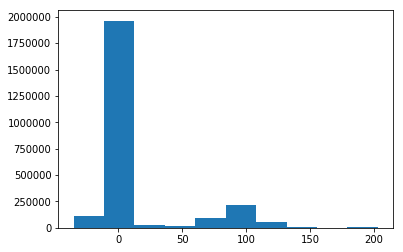

In [19]:

#train[dep_var].hist(), 
plt.hist(np.concatenate(fin_preds))

# ooValidation set

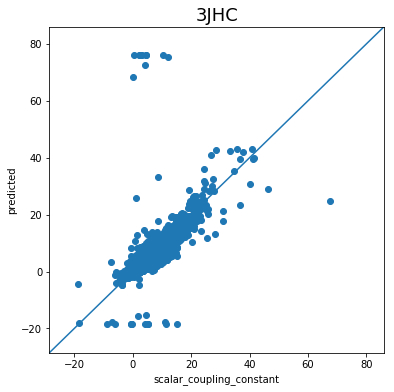

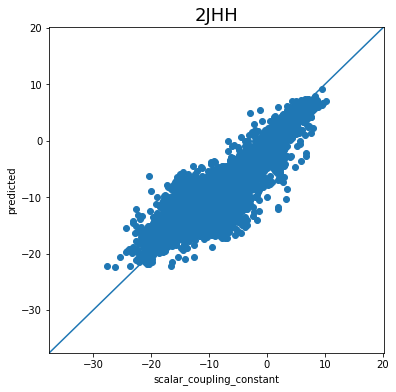

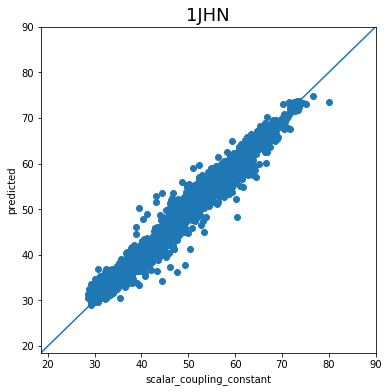

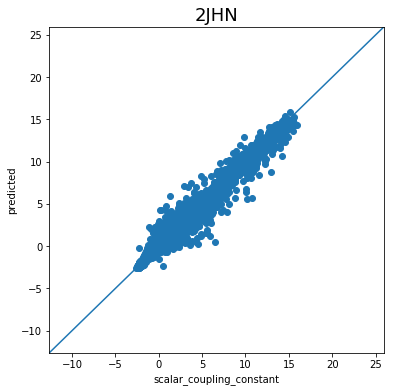

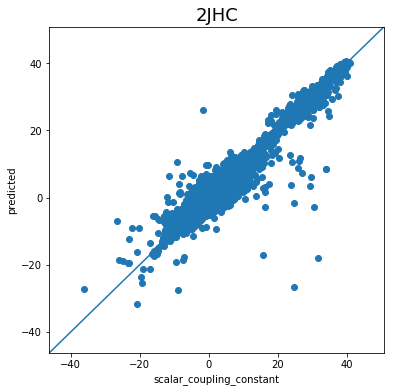

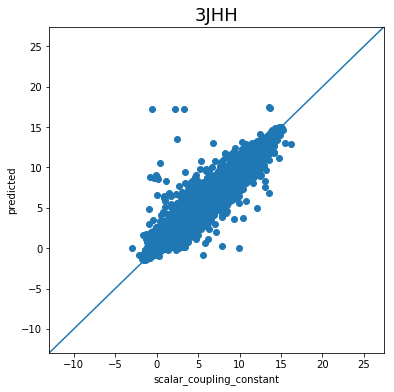

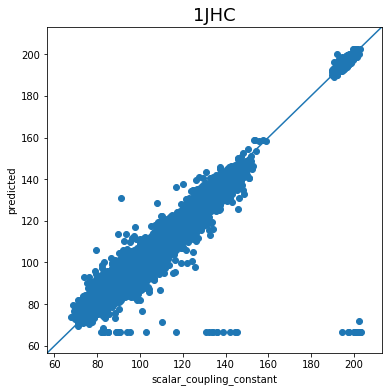

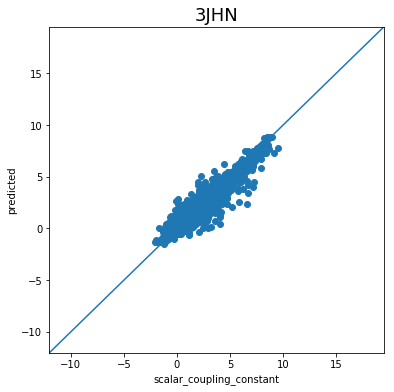

In [20]:
for i,t in enumerate(types_to_run):
    plt.figure(figsize=(6,6))
    plt.scatter(x=y_valid_nn_a[i], y=fin_preds_valid[i])
    
    llim =min(np.min(fin_preds_valid[i]),np.min(y_valid_nn_a[i]))-10
    ulim=max(np.max(fin_preds_valid[i]),np.max(y_valid_nn_a[i]))+10
    
    plt.xlabel('scalar_coupling_constant')
    plt.ylabel('predicted')
    plt.xlim((llim, ulim))
    plt.ylim((llim, ulim))
    plt.plot([llim, ulim], [llim, ulim])
    plt.title(t, fontsize=18)
    plt.show()

## oo Train Set

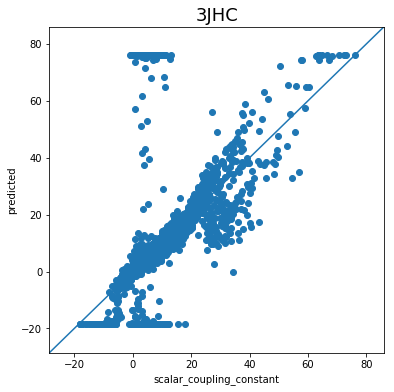

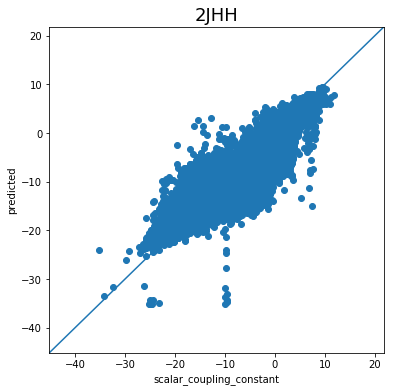

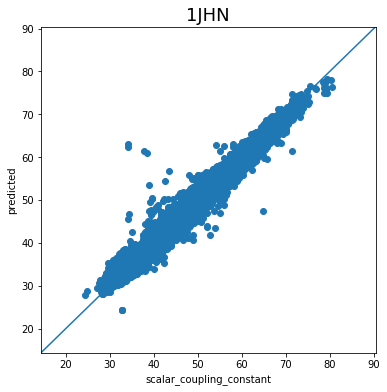

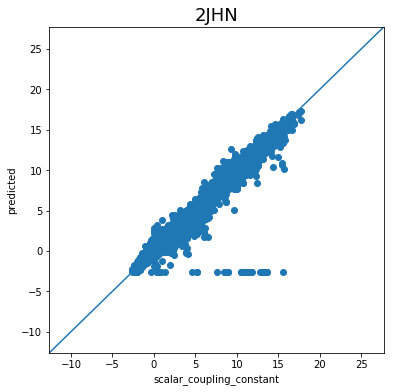

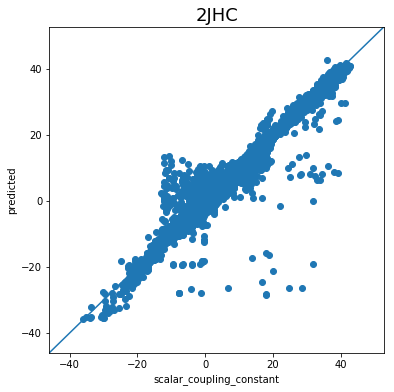

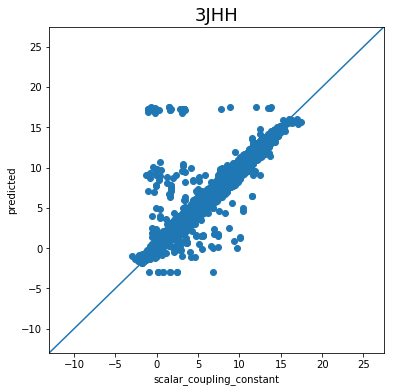

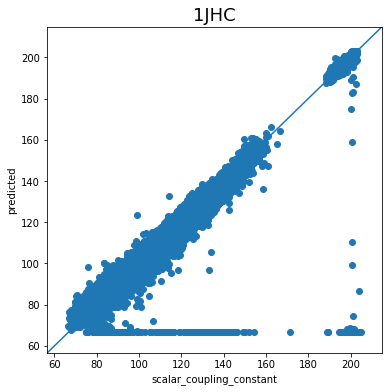

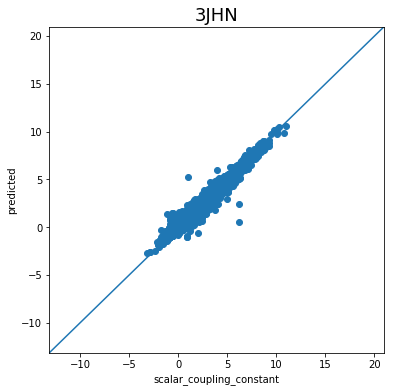

In [21]:
for i,t in enumerate(types_to_run):
    plt.figure(figsize=(6,6))
    plt.scatter(x=y_train_nn_a[i], y=fin_preds_train[i])
    
    llim =min(np.min(fin_preds_train[i]),np.min(y_train_nn_a[i]))-10
    ulim=max(np.max(fin_preds_train[i]),np.max(y_train_nn_a[i]))+10
    
    plt.xlabel('scalar_coupling_constant')
    plt.ylabel('predicted')
    plt.xlim((llim, ulim))
    plt.ylim((llim, ulim))
    plt.plot([llim, ulim], [llim, ulim])
    plt.title(t, fontsize=18)
    plt.show()

## Predictions

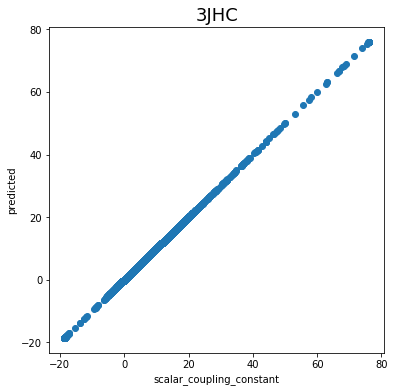

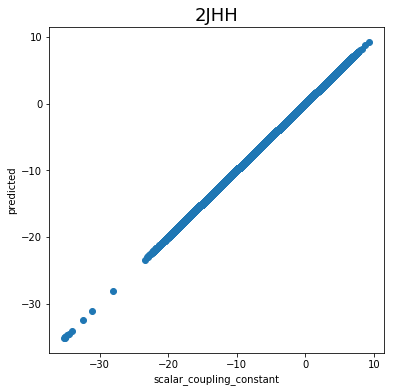

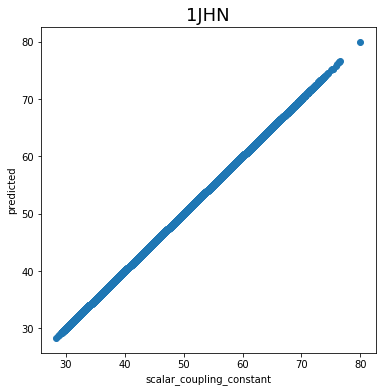

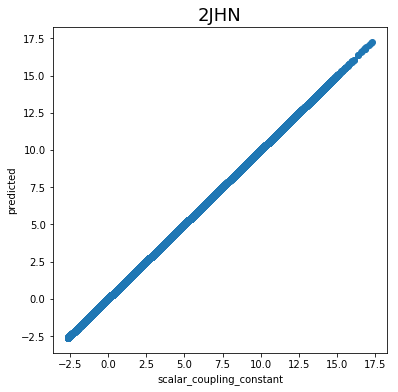

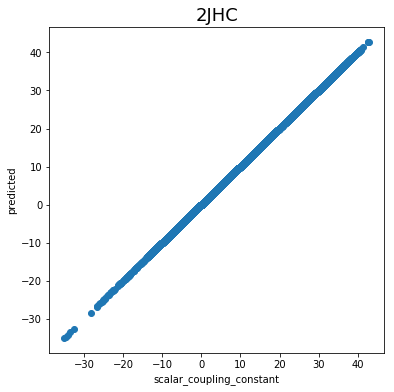

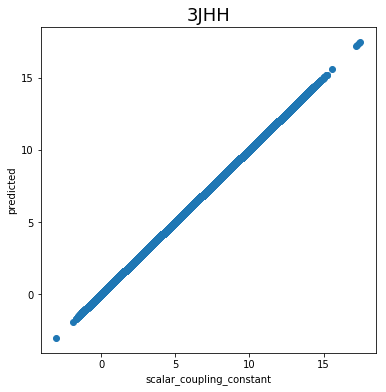

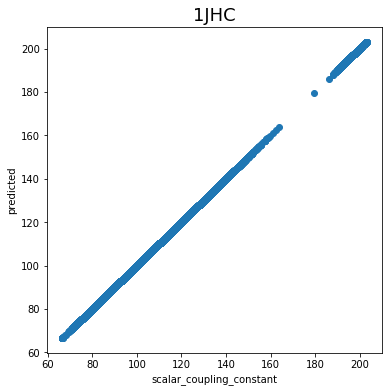

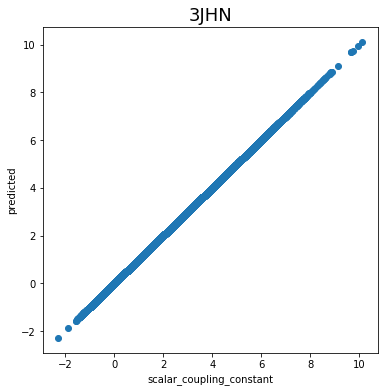

In [22]:
for i,t in enumerate(types_to_run):
    plt.figure(figsize=(6,6))
    
    plt.scatter(x=fin_preds[i], y=fin_preds[i])
    
    plt.xlabel('scalar_coupling_constant')
    plt.ylabel('predicted')
    plt.title(t, fontsize=18)
    plt.show()